### Imports

In [1]:
# Import libraries needed for webscraping
import requests
from datetime import datetime
import time
import random
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import regex as re
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize, RegexpTokenizer

from bs4 import BeautifulSoup    

import unidecode
import contractions
import redditcleaner
import spacy
#spacy.cli.download('en_core_web_md')
#spacy.cli.download('en_core_web_sm')

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

In [112]:
#!pip install contractions

     ---------------------------------------- 0.0/289.9 kB ? eta -:--:--
     ------------------ ------------------- 143.4/289.9 kB 4.3 MB/s eta 0:00:01
     -------------------------------------- 289.9/289.9 kB 3.6 MB/s eta 0:00:00


In [227]:
#pip install redditcleaner

Note: you may need to restart the kernel to use updated packages.


### Load Data

In [6]:
awardtravel = pd.read_csv('../data/awardtravel_4000.csv')
backpacking = pd.read_csv('../data/backpacking_4000.csv')

### Basic data cleaning

#### Check for removed, deleted, NaN posts
    Instead of dropping those value, I replaced them with empty string because the titles still capatured the information about the posts.  

In [7]:
backpacking.head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
0,backpacking,"Hi. I'm from kokan, Maharashtra.and want to tr...",Where to find snow in April third week,NaN,Due-Use1142,NaN,0,4/2/2023 6:44
1,backpacking,"Hey, me and my friend are planning to go on a ...","I'm planning a backpacking trip to Romania, an...",NaN,wbtr42,NaN,0,4/2/2023 6:35
2,backpacking,I'm planning my first backpacking trip with so...,Week long backpacking trails in Big Horns Clou...,NaN,juicy__nuggets,NaN,0,4/2/2023 4:36
3,backpacking,[removed],Most beautiful places to visit in Arizona,NaN,exploreofficial,moderator,0,4/2/2023 4:03
4,backpacking,[removed],MOST BEAUTIFUL PLACES TO VISIT IN ARIZONA,NaN,exploreofficial,moderator,0,4/2/2023 3:41


In [8]:
# check null value: no null value for title but 516 null calue for selftext
backpacking.isna().sum()

subreddit                 0
selftext               1792
title                     0
distinguished          3749
author                    0
removed_by_category    3020
num_comments              0
utc_datetime_str          0
dtype: int64

In [9]:
# even it showed nan for selftext, title still have content
backpacking[backpacking['selftext'].isnull()].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
7,backpacking,NaN,الشاطئ الصخري - سيدي حنيش - مرسي مطروح - sidi ...,NaN,kingofgamaleya,NaN,1,4/2/2023 3:07
8,backpacking,NaN,Packing for my first trip to Joshua Tree and r...,NaN,ObjectiveCaregiver16,reddit,1,4/2/2023 0:37
12,backpacking,NaN,Glacier NP Aug. 2019,NaN,daysengrave,NaN,1,4/1/2023 23:18
16,backpacking,NaN,"Calm weather in Unalaklet,Alaska",NaN,AlaskanHusky14,NaN,1,4/1/2023 20:54
17,backpacking,NaN,"Unalaklet, ALASKA,",NaN,AlaskanHusky14,NaN,1,4/1/2023 20:50


In [10]:
# replace Nan with empty string
backpacking['selftext'] = backpacking['selftext'].fillna('')

In [11]:
# checking for both removed or deleted posts
backpacking.loc[backpacking['selftext'].str.contains(r'\[removed\]|\[deleted\]')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
3,backpacking,[removed],Most beautiful places to visit in Arizona,NaN,exploreofficial,moderator,0,4/2/2023 4:03
4,backpacking,[removed],MOST BEAUTIFUL PLACES TO VISIT IN ARIZONA,NaN,exploreofficial,moderator,0,4/2/2023 3:41
5,backpacking,[removed],MOST BEAUTIFUL PLACES TO VISIT IN FRANCE OTHER...,NaN,exploreofficial,moderator,0,4/2/2023 3:35
10,backpacking,[removed],What is the best backpack to travel the world in?,NaN,silentdragon010101,moderator,1,4/2/2023 0:06
19,backpacking,[removed],Cotopaxi or osprey,NaN,AdvanceDry2521,moderator,1,4/1/2023 20:30


In [12]:
# replace 'remove' and 'deleted' since the title still have information about the post
backpacking['selftext'] = backpacking['selftext'].replace('[removed]', '')
backpacking['selftext'] = backpacking['selftext'].replace('[deleted]', '')

In [13]:
awardtravel.head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
0,awardtravel,Got about 400k MR. Would like business for 2 t...,Sfo to hkg january time frame,NaN,NorcalGamers627,NaN,1,4/2/2023 4:55
1,awardtravel,Hey - we have about \~200K AmEx points saved u...,Best way to fly to Japan in business or 1st cl...,NaN,altoid_trapezoid,NaN,1,4/2/2023 3:43
2,awardtravel,"Finally!! Got the booking confirmed for two ,\...",booked JAL F for two via Cathay!!! But now adv...,NaN,Leezy36,NaN,1,4/2/2023 3:07
3,awardtravel,Hoping to plan a Japan ski trip for Jan/Feb 20...,ANA Stopover Question,NaN,SnooDoughnuts785,NaN,1,4/2/2023 1:25
4,awardtravel,I booked an EgyptAir flight that connects in C...,Is it possible to ask for a longer layover on ...,NaN,ReasonWithMe007,NaN,1,4/2/2023 0:43


In [14]:
awardtravel.isna().sum()

subreddit                 0
selftext                 88
title                     0
distinguished          3948
author                    0
removed_by_category    3474
num_comments              0
utc_datetime_str          0
dtype: int64

In [15]:
# even it showed nan for selftext, title still have content
awardtravel[awardtravel['selftext'].isnull()].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
13,awardtravel,NaN,"i fly a lot, so my friends came to me to use m...",NaN,professional_pupper,NaN,1,4/1/2023 17:11
36,awardtravel,NaN,Can't search on AF/KLM,NaN,ebpomtl,NaN,1,3/31/2023 12:11
83,awardtravel,NaN,"Quickest way to offload my remaining 80,000 Wo...",NaN,vialpandomc,NaN,1,3/29/2023 19:08
88,awardtravel,NaN,Global Entry/Trusted Traveler Appointment Finder,NaN,toastingdetermined,moderator,1,3/29/2023 16:31
105,awardtravel,NaN,question if I book award flight in economy on ...,NaN,Mysterious_Pie_4594,NaN,1,3/28/2023 19:27


In [16]:
# replace Nan with empty string
awardtravel['selftext'] = awardtravel['selftext'].fillna('')

In [17]:
# checking for both removed or deleted posts
awardtravel.loc[awardtravel['selftext'].str.contains(r'\[removed\]|\[deleted\]')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
31,awardtravel,[removed],Marriott and United - Comparing Miles earned p...,NaN,Tejavepa,reddit,0,3/31/2023 16:42
82,awardtravel,[removed],First time booking with chase (or any credit c...,NaN,eroxal,moderator,1,3/29/2023 19:16
84,awardtravel,[removed],When the Chase portal hotels are way overprice...,NaN,airplanedad,moderator,1,3/29/2023 18:03
94,awardtravel,[removed],Horton Studios,NaN,zhinocoaster,reddit,1,3/29/2023 13:16
119,awardtravel,[removed],Cabo Award Flights,NaN,Lil_Mikee,moderator,0,3/28/2023 6:41


In [18]:
# replace 'remove' and 'deleted' since the title still have information about the post
awardtravel['selftext'] = awardtravel['selftext'].replace('[removed]', '')
awardtravel['selftext'] = awardtravel['selftext'].replace('[deleted]', '')

#### Check for weekly mod posts from the moderators of the subreddit: 
    Some subreddits would post weekly announcements, daily surveys, or recommendations. Since these posts were posted on the weekly/daily bases with similar titles or contents, it's best to remove these posts to avoid skewness of some words. After checking, both subreddits do not have such issue.

In [19]:
backpacking['author'].value_counts()

Civil-Dragonfruit337    38
intofarlands            36
Yusuf-Uyghur            20
George_Kein             16
ComfortableCommon561    15
                        ..
trendstori               1
cocaiakes_03             1
MundaneBodybuilder61     1
Sethpolma                1
OasisRips                1
Name: author, Length: 2558, dtype: int64

In [22]:
# posts from Civil-Dragonfruit337 are not mod posts; will keep them
backpacking.loc[backpacking['author'].str.contains(r'Civil-Dragonfruit337')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
212,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,3/27/2023 8:05
483,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,3/20/2023 8:05
965,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,3/6/2023 9:05
1489,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,2/20/2023 9:05
1714,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,2/13/2023 9:05


In [24]:
# posts from backpacking are mod posts; will drop them
backpacking.loc[backpacking['author'].str.contains(r'AutoModerator')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
212,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,3/27/2023 8:05
483,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,3/20/2023 8:05
965,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,3/6/2023 9:05
1489,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,2/20/2023 9:05
1714,backpacking,"If you have any beginner questions, feel free ...",Weekly /r/backpacking beginner question thread...,NaN,AutoModerator,NaN,0,2/13/2023 9:05


In [25]:
# will remove the posts that were deleted; 
# because the post may be removed for many other reasons: spam, author removed, advertisements
backpacking.loc[backpacking['author'].str.contains(r'delete')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
77,backpacking,,Xiikiukhm,NaN,[deleted],deleted,1,3/31/2023 9:32
801,backpacking,,Travel insurance/gadget cover,NaN,[deleted],deleted,1,3/11/2023 14:32
1162,backpacking,,6 weeks in Thailand - should I start in Chiang...,NaN,[deleted],deleted,1,3/1/2023 1:32
1353,backpacking,,What are some niche things that you don't see ...,NaN,[deleted],deleted,1,2/23/2023 15:15
1866,backpacking,,Smallish rant about Nemo’s customer service,NaN,[deleted],deleted,0,2/8/2023 2:45


In [26]:
awardtravel['author'].value_counts()

[deleted]               77
AutoModerator           24
Automatic_Team_4280     11
Lolgb2000               11
dsper32                 11
                        ..
autobotdonttransform     1
keithmg                  1
someguywithanaccount     1
karI_hungus              1
jarjargo44               1
Name: author, Length: 2897, dtype: int64

In [27]:
awardtravel.loc[awardtravel['author'].str.contains(r'AutoModerator')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
147,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - March 27, 2023",NaN,AutoModerator,NaN,0,3/27/2023 10:01
458,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - March 13, 2023",NaN,AutoModerator,NaN,0,3/13/2023 10:01
624,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - March 06, 2023",NaN,AutoModerator,NaN,0,3/6/2023 11:01
806,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - February 27, 2023",NaN,AutoModerator,NaN,0,2/27/2023 11:01
970,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - February 20, 2023",NaN,AutoModerator,NaN,0,2/20/2023 11:01


In [28]:
# will remove the posts that were deleted; 
# because the post may be removed for many other reasons: spam, author removed, advertisements. duplicate posts
awardtravel.loc[awardtravel['author'].str.contains(r'\[deleted\]')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
760,awardtravel,,What's the best MR to LifeMiles bonus you've seen,NaN,[deleted],deleted,2,3/1/2023 6:26
762,awardtravel,,concerned about missing my connecting flights ...,NaN,[deleted],deleted,3,3/1/2023 4:11
1830,awardtravel,,Can I be added to a Marriott account to obtain...,NaN,[deleted],deleted,1,1/17/2023 1:09
2065,awardtravel,,Can a paid upgrade with BA from economy to pre...,NaN,[deleted],deleted,0,1/9/2023 6:48
2957,awardtravel,,Close-In Availability Game Prep: USA =&gt; SYD...,NaN,[deleted],deleted,1,12/2/2022 22:34


In [30]:
# drop moderator posts
backpacking.drop(index=backpacking[backpacking['author'].str.contains('AutoModerator|deleted')].index, inplace=True)
awardtravel.drop(index=awardtravel[awardtravel['author'].str.contains('AutoModerator|deleted')].index, inplace=True)

In [31]:
backpacking.shape, awardtravel.shape

((3731, 8), (3847, 8))

#### Drop unwanted columns: 

In [33]:
# Check for null values
backpacking.isnull().sum()[backpacking.isnull().sum() > 0]

distinguished          3731
removed_by_category    3010
dtype: int64

In [34]:
# Check for null values
awardtravel.isnull().sum()[awardtravel.isnull().sum() > 0]

distinguished          3847
removed_by_category    3450
dtype: int64

In [35]:
backpacking.drop(columns = ['distinguished', 'removed_by_category'], inplace = True)
awardtravel.drop(columns = ['distinguished', 'removed_by_category'], inplace = True)

In [36]:
backpacking.isna().sum()

subreddit           0
selftext            0
title               0
author              0
num_comments        0
utc_datetime_str    0
dtype: int64

In [37]:
awardtravel.isna().sum()

subreddit           0
selftext            0
title               0
author              0
num_comments        0
utc_datetime_str    0
dtype: int64

In [38]:
#number of posts per user
backpacking.groupby(['author'])['subreddit'].agg(['count']).sort_values('count', ascending = False).head(10)

,count
author,
Civil-Dragonfruit337,38
intofarlands,36
Yusuf-Uyghur,20
George_Kein,16
External_Fortune_324,15
ComfortableCommon561,15
bestproductreviews3,14
hobbymart8888,14
s34nvideos,13


In [39]:
#number of posts per user
awardtravel.groupby(['author'])['subreddit'].agg(['count']).sort_values('count', ascending = False).head(10)

,count
author,
Automatic_Team_4280,11
Lolgb2000,11
dsper32,11
Automatic_Aspect_319,10
slidinginlife,8
SnooDoughnuts785,8
AbhiAKA,8
No-Competition-8938,8
dickniglit,7


In [40]:
backpacking.describe()

,num_comments
count,3731.000000
mean,0.551595
std,1.009448
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,46.000000


In [41]:
awardtravel.describe()

,num_comments
count,3847.000000
mean,1.998440
std,5.404636
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,94.000000


#### Check for duplicate rows: 
    Should not have any duplicate rows since they should have been dropped during scrapping steps. 

In [42]:
backpacking.duplicated(subset=['selftext','title']).value_counts()

False    3731
dtype: int64

In [43]:
awardtravel.duplicated(subset=['selftext','title']).value_counts()

False    3847
dtype: int64

#### Combine two dataframes for futher cleaning and data training

In [44]:
backpacking.shape, awardtravel.shape

((3731, 6), (3847, 6))

In [46]:
# combined and reset index
df_combined_ab = pd.concat([backpacking, awardtravel], axis = 0)
df_combined_ab = df_combined_ab.reset_index(drop=True)

In [47]:
df_combined_ab.shape

(7578, 6)

In [48]:
df_combined_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7578 entries, 0 to 7577
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         7578 non-null   object
 1   selftext          7578 non-null   object
 2   title             7578 non-null   object
 3   author            7578 non-null   object
 4   num_comments      7578 non-null   int64 
 5   utc_datetime_str  7578 non-null   object
dtypes: int64(1), object(5)
memory usage: 355.3+ KB


In [49]:
df_combined_ab.subreddit.value_counts()

awardtravel    3847
backpacking    3731
Name: subreddit, dtype: int64

In [50]:
#convert the target into binary result
df_combined_ab['subreddit'].replace({'backpacking': 1, 'awardtravel': 0}, inplace=True)

In [51]:
df_combined_ab.subreddit.value_counts()

0    3847
1    3731
Name: subreddit, dtype: int64

#### Create 'text' column to capture the content of both selftext and title

In [52]:
# Create 'text' column = Combination of selftext and title

df_combined_ab['text'] = df_combined_ab['title'] + ' ' + df_combined_ab['selftext']
df_combined_ab.head()

,subreddit,selftext,title,author,num_comments,utc_datetime_str,text
0,1,"Hi. I'm from kokan, Maharashtra.and want to tr...",Where to find snow in April third week,Due-Use1142,0,4/2/2023 6:44,Where to find snow in April third week Hi. I'm...
1,1,"Hey, me and my friend are planning to go on a ...","I'm planning a backpacking trip to Romania, an...",wbtr42,0,4/2/2023 6:35,"I'm planning a backpacking trip to Romania, an..."
2,1,I'm planning my first backpacking trip with so...,Week long backpacking trails in Big Horns Clou...,juicy__nuggets,0,4/2/2023 4:36,Week long backpacking trails in Big Horns Clou...
3,1,,Most beautiful places to visit in Arizona,exploreofficial,0,4/2/2023 4:03,Most beautiful places to visit in Arizona
4,1,,MOST BEAUTIFUL PLACES TO VISIT IN ARIZONA,exploreofficial,0,4/2/2023 3:41,MOST BEAUTIFUL PLACES TO VISIT IN ARIZONA


In [53]:
df_combined_ab.groupby('subreddit')['num_comments'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,3847.0,1.998440,5.404636,0.0,1.0,1.0,1.0,94.0
1,3731.0,0.551595,1.009448,0.0,0.0,1.0,1.0,46.0


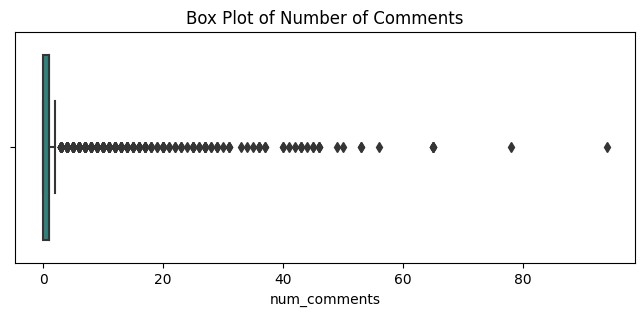

In [54]:
plt.figure(figsize=(8, 3))
sns.boxplot(data = df_combined_ab, x = 'num_comments', palette = 'viridis')
plt.title("Box Plot of Number of Comments");

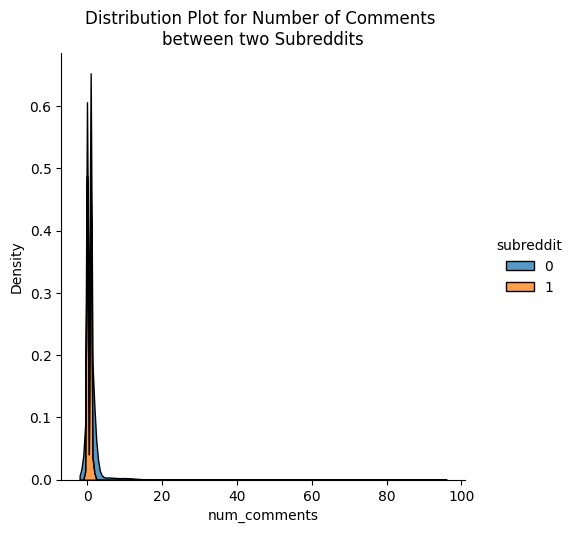

In [56]:
sns.displot(x='num_comments', data=df_combined_ab, hue='subreddit', kind="kde", multiple="stack")
plt.title('Distribution Plot for Number of Comments \nbetween two Subreddits');

In [57]:
# drop columns that are not needed for analysis
df_combined_ab.drop(columns = ['utc_datetime_str', 'selftext'], inplace = True)

In [58]:
df_combined_ab.shape

(7578, 5)

In [59]:
df_combined_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7578 entries, 0 to 7577
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     7578 non-null   int64 
 1   title         7578 non-null   object
 2   author        7578 non-null   object
 3   num_comments  7578 non-null   int64 
 4   text          7578 non-null   object
dtypes: int64(2), object(3)
memory usage: 296.1+ KB


In [60]:
# Save to csv
df_combined_ab.to_csv("../data/df_combined_ab.csv", index=False)

In [61]:
df_combined_ab = pd.read_csv('../data/df_combined_ab.csv')

### Text preprocessing

In [65]:
# credit https://stackabuse.com/removing-stop-words-from-strings-in-python/
sp = spacy.load('en_core_web_sm')

stopwords_sp = sp.Defaults.stop_words
#stopwords_sp.remove('not')
print(stopwords_sp)


{'nevertheless', 'moreover', 'you', 'full', 'when', '’re', 'make', 'quite', 'yours', 'last', 'next', 'too', 'noone', '’s', 'serious', 'wherever', 'thru', 'doing', 'few', 'him', 'whence', 'he', 'most', 'well', 'across', 'his', 'otherwise', 'yourselves', 'without', 'now', 'eleven', 'much', 'none', 'beyond', 'forty', 'as', 'anyone', 'during', 'all', 'n’t', 'used', 'often', 'front', 'other', 'whither', '‘s', 'put', 'since', 'see', 'what', 'throughout', '’ll', 'on', 'whatever', 'unless', 'how', 'fifty', 'from', 'fifteen', 'whole', 'either', 'toward', 'someone', 'anything', 'to', 'please', 'ours', 'within', 'top', 'besides', "'re", 'between', 'sometimes', 'almost', 'three', 'meanwhile', 'six', 'ourselves', "'ll", 'its', 'so', 'already', 'would', 'both', 'once', 'five', 'except', 'those', 'whereupon', 'everything', 'above', 'if', "'ve", 'show', 'my', 'has', '‘re', 'these', 'part', 'this', 'she', 'hers', 'among', 'ever', 'latterly', 'alone', 'ca', 'latter', 'per', 'name', 'i', 'whether', 'ever

In [66]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize

In [67]:
from nltk.stem import WordNetLemmatizer

In [68]:
stopwords = set(stopwords.words('english'))
#stopwords.remove('not')

In [69]:
print(stopwords)

{'at', 'ain', 'them', 'some', 'their', 'you', 'while', 'not', 'be', 'just', 'until', 'hadn', 'o', 'when', 'any', 'ourselves', 'your', "you'll", 'the', 'and', 'yours', 'its', "she's", 'more', 'yourself', 'himself', 'further', 'so', "doesn't", 'down', 'too', 'before', 'needn', 'where', 'both', 've', "wasn't", 'once', "don't", 'because', "that'll", "shouldn't", 'it', 'themselves', "wouldn't", 'those', 'doing', 'few', "couldn't", 'ma', 'above', 'after', 'if', 'him', 'no', 'he', "mustn't", 'having', 'will', "hadn't", 'most', 'my', "you'd", 'has', 'doesn', 'out', 'such', 'his', 'won', 'yourselves', 'which', "haven't", 'these', "isn't", 'this', 'being', 'she', 'hasn', 'now', 'hers', 'haven', 'mustn', 'again', 'll', 'than', 'are', 'her', 'as', "needn't", 'have', 'during', 'a', 'we', 'i', 'all', 'under', 't', 'isn', "weren't", "hasn't", 'herself', 'same', 'can', 's', 'through', 'd', 'below', 'been', 'there', 'very', 'should', 're', 'that', 'up', 'over', 'shouldn', 'then', 'other', 'does', 'why'

In [70]:
# credit: https://www.w3schools.com/python/gloss_python_join_sets.asp
all_stopwords = stopwords_sp.union(stopwords)

In [71]:
print(all_stopwords)

{'nevertheless', 'ain', 'moreover', 'them', 'some', 'side', 'their', 'you', 'while', 'full', 'just', '‘ve', 'upon', 'o', 'when', '’ve', '’re', 'any', 'make', 'somehow', 'quite', 'and', 'yours', 'last', 'hereby', 'more', 'yet', 'further', 'himself', 'next', 'too', 'needn', 'noone', 'wherein', 'where', 've', 'always', 'everywhere', '’s', 'must', 'because', 'serious', "that'll", 'mostly', 'mine', 'it', 'themselves', 'via', "n't", 'wherever', 'thru', 'doing', 'few', 'seemed', 'ma', 'seem', 'him', 'whence', 'he', 'together', 'anyway', 'n‘t', 'will', 'having', 'most', 'around', 'well', "you'd", 'across', 'doesn', 'whose', 'such', 'his', 'beside', 'won', 'otherwise', 'yourselves', "haven't", 'another', "isn't", 'being', 'nine', 'without', '’m', 'hasn', 'now', 'beforehand', 'eleven', 'haven', 'much', 'none', 'beyond', 'forty', 'thereupon', 'thence', 'are', 'as', 'anyone', 'thereby', "needn't", 'during', 'we', "'d", 'anywhere', 'all', 'elsewhere', 'hereafter', "weren't", 'n’t', "hasn't", 'same'

In [58]:
# additional keywords for removal
#add_stopwords = ['www', '.com', 'com', 'http', 'https']
#add_stopwords = set(add_stopwords)
#type(add_stopwords)

set

In [59]:
#more_stopwords = all_stopwords.union(add_stopwords)
#print(more_stopwords)

{'empty', 'under', 'via', 'can', 'first', "shouldn't", 'therein', "'ll", 'bottom', 'take', 'further', 'meanwhile', 'somewhere', 'anyone', 'many', 'may', 'ca', "couldn't", 'eight', 'six', 'each', "should've", 'none', 'hundred', 'anything', 'seems', 'sometime', 'couldn', 'over', 've', 'whereas', 'she', 'never', 'seeming', 'until', 'last', 'five', 'of', 'mine', 'quite', "doesn't", 'around', 'between', 'mustn', 'aren', 'down', 'often', 'or', 'put', 'another', 'together', '.com', 'least', 'full', 'well', 'n’t', '‘ll', '’s', 'by', "you're", 'who', 'theirs', 'everyone', 'sixty', 'above', 'again', 'using', 'if', 'yourselves', 'for', 'else', 'whereafter', 'third', 'amount', 'their', 'weren', 'did', 'them', 'indeed', 'whereby', "isn't", 'fifty', 'up', 'more', "it's", 'haven', 'thereafter', 'afterwards', 'latter', 'http', 'along', 'this', "wouldn't", 'whatever', 'somehow', "shan't", 'while', 'except', 'same', 'n‘t', 'only', "hasn't", "she's", 'top', 'were', "n't", 'as', 'whoever', "'ve", "that'll

#### Tokenizing

In [ ]:
# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+') 


#### Function for text cleaning

In [72]:
df_combined_ab = pd.read_csv('../data/df_combined_ab.csv')

In [73]:
# adopted from class
# credit: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
# credit: https://www.geeksforgeeks.org/python-removing-newline-character-from-string/
# credit: https://stackoverflow.com/questions/43356467/removing-special-characters-and-symbols-from-a-string-in-python
# credit: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
# credit: https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb
# credit: https://pypi.org/project/redditcleaner/

# initialize list of newline characters
#newline_characters = ['\\ng', 'i\ns', 'b\nest', '\n\n', '\n', '\t', '\\']

def preprocess(text):

    # use redditcleaner to remove special characters used in the raw text at reddit
    # such as &amp;#x200B, newline_characters (\n\n)
    text = redditcleaner.clean(text)  
    
    # using contractions.fix to expand the shortened words
    text = contractions.fix(text)
        
    # convert to lowercase
    text = text.lower()
    
    # initiate BeautifulSopu to strip HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ") # Get all the text other than html tags.
    
    # remove links starts with https and/or end with .com
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\ *\.com', '', text)
    
    # remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)    
    
    # remove newlines tabs
    #for characters in newline_characters:
    #    text = text.replace(characters, ' ') 
    
    # remove extra white spaces
    text = re.sub('\s+', ' ', text).strip()  
  
    # split into individual words
    words = text.split()
        
    # remove stop words
    meaningful_words = []
    for w in words:
        if w not in all_stopwords:
            meaningful_words.append(w)
              
    # lemmatizer the words
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]    
    
    return ' '.join(tokens_lem)

In [74]:
df_combined_ab['text_cleaned'] = df_combined_ab.apply(lambda x: preprocess(x['text']), axis=1)
df_combined_ab.head()

C:\Users\skyne\AppData\Local\Temp\ipykernel_31392\2602187967.py:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\skyne\AppData\Local\Temp\ipykernel_31392\2602187967.py:25: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,subreddit,title,author,num_comments,text,text_cleaned
0,1,Where to find snow in April third week,Due-Use1142,0,Where to find snow in April third week Hi. I'm...,find snow april week hi kokan maharashtra want...
1,1,"I'm planning a backpacking trip to Romania, an...",wbtr42,0,"I'm planning a backpacking trip to Romania, an...",planning backpacking trip romania tip hey frie...
2,1,Week long backpacking trails in Big Horns Clou...,juicy__nuggets,0,Week long backpacking trails in Big Horns Clou...,week long backpacking trail big horn cloud pea...
3,1,Most beautiful places to visit in Arizona,exploreofficial,0,Most beautiful places to visit in Arizona,beautiful place visit arizona
4,1,MOST BEAUTIFUL PLACES TO VISIT IN ARIZONA,exploreofficial,0,MOST BEAUTIFUL PLACES TO VISIT IN ARIZONA,beautiful place visit arizona


In [75]:
# before text cleaning
df_combined_ab['text'][0:5].unique()

array(["Where to find snow in April third week Hi. I'm from kokan, Maharashtra.and want to travel to himachal pradesh to escape from hot summer.\nSo will there be any snow clad landscapes in April third week of this year? Also is it advisable to take 2 years old toddler along? I'm looking for budget tour , nature exploration, a little increment bit of snow. Can anyone suggest best itenary. I would like to skip simala, Manali.",
       "I'm planning a backpacking trip to Romania, any tips? Hey, me and my friend are planning to go on a two-week backpacking trip to romania this summer. Any tips what we should not miss or what to be cautious about?",
       "Week long backpacking trails in Big Horns Cloud Peak wilderness I'm planning my first backpacking trip with some friends in the Cloud Peak Wilderness area but none of us have any idea what route to take. One that lasts 4-6 days to travel should do.",
       'Most beautiful places to visit in Arizona ',
       'MOST BEAUTIFUL PLACES TO 

In [76]:
# after text cleaning
df_combined_ab['text_cleaned'][0:5].unique()

array(['find snow april week hi kokan maharashtra want travel himachal pradesh escape hot summer snow clad landscape april week year advisable year old toddler looking budget tour nature exploration little increment bit snow suggest best itenary like skip simala manali',
       'planning backpacking trip romania tip hey friend planning week backpacking trip romania summer tip miss cautious',
       'week long backpacking trail big horn cloud peak wilderness planning backpacking trip friend cloud peak wilderness area idea route last day travel',
       'beautiful place visit arizona'], dtype=object)

In [77]:
df_combined_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7578 entries, 0 to 7577
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     7578 non-null   int64 
 1   title         7578 non-null   object
 2   author        7578 non-null   object
 3   num_comments  7578 non-null   int64 
 4   text          7578 non-null   object
 5   text_cleaned  7578 non-null   object
dtypes: int64(2), object(4)
memory usage: 355.3+ KB


In [78]:
# Save to csv
df_combined_ab.to_csv("../data/df_cleaned_ab.csv", index=False)